### 공공데이터 포털 https://www.data.go.kr/

In [3]:
# 다운로드 : CSV
# OPEN API : JSON

### OPEN API

- 공공데이터포털(data.go.kr) OpenAPI로 데이터 수집 → Pandas 데이터프레임 변환 → 분석/저장/재사용

#### A. 활용신청 & 인증키(ServiceKey) 받기

- 공공데이터포털에서 원하는 API 검색 : 데이터 목록 - 오픈API
- API 상세 페이지에서 활용신청
- 승인 후 마이페이지 → 일반인증키(Decoding/Encoding) 확인 - 인증키 복사
- API 호출	requests 등으로 호출 → JSON 응답 수신 
- DataFrame 변환 → 분석	상관/회귀 등 통계적 분석 수행

- 보통 URL 파라미터로는 Encoding 키를 쓰는 경우가 많지만, API마다 다를 수 있다.
- 문서에 serviceKey 파라미터가 있고 “URL Encode된 키”를 요구하면 Encoding 키를 넣습니다.

#### B. 요청 형태 확인(문서에서 꼭 볼 것)

- API 문서에서 아래를 확인하세요.
- Endpoint(URL): 예) https://apis.data.go.kr/xxxxx/xxxxx
- 필수 파라미터: serviceKey, 날짜/지역/페이지 등
- 응답 포맷: JSON / XML
- 페이징 방식: pageNo, numOfRows (또는 page, perPage)
- 응답 구조: 실제 데이터가 들어있는 키(예: items, item, data, body 등)
- 정상 코드: resultCode, resultMsg 같은 필드 존재 여부

# 문제정의
 - 코스피 지수 데이터를 기반으로 시장상황에 대해 이해하고싶다.

###  OpenAPI 호출

In [2]:
# requests + JSON 기준

In [3]:
import requests
import pandas as pd
from urllib.parse import unquote
from datetime import datetime, timedelta

API_KEY = "wvDbY6YoQw92S3N5raUlsAtKC41aKHFfYFriQAdeVMk7xDhCbZ8M0EFpwy7JK8RLYTRBjDKJU13/RUQPJUaXMw=="
URL = "https://apis.data.go.kr/1160100/service/GetMarketIndexInfoService/getStockMarketIndex"

params = {
    "serviceKey": API_KEY,
    "resultType": "json",
    "pageNo": 1,
    "numOfRows": 1000,
    "idxNm": "코스피",      # 지수명
    "beginBasDt":20240101
}


headers = {"User-Agent": "Mozilla/5.0"}
resp = requests.get(URL, params=params, headers=headers, timeout=30)

print("status:", resp.status_code)
print("content-type:", resp.headers.get("Content-Type"))
print("request url:", resp.url)

print(resp)
# JSON 파싱 (정상일 때만)
data = resp.json()

# API 결과 체크
header = data.get("response", {}).get("header", {})
print("resultCode:", header.get("resultCode"))
print("resultMsg:", header.get("resultMsg"))

items = data["response"]["body"]["items"]["item"]
df = pd.DataFrame(items)
print(df.head())


status: 200
content-type: application/json; charset=UTF-8
request url: https://apis.data.go.kr/1160100/service/GetMarketIndexInfoService/getStockMarketIndex?serviceKey=wvDbY6YoQw92S3N5raUlsAtKC41aKHFfYFriQAdeVMk7xDhCbZ8M0EFpwy7JK8RLYTRBjDKJU13%2FRUQPJUaXMw%3D%3D&resultType=json&pageNo=1&numOfRows=1000&idxNm=%EC%BD%94%EC%8A%A4%ED%94%BC&beginBasDt=20240101
<Response [200]>
resultCode: 00
resultMsg: NORMAL SERVICE.
      basDt idxNm    idxCsf epyItmsCnt     clpr     vs fltRt      mkp  \
0  20251226   코스피  KOSPI시리즈        843  4129.68  21.06   .51  4130.37   
1  20251224   코스피  KOSPI시리즈        843  4108.62   -8.7  -.21  4136.24   
2  20251223   코스피  KOSPI시리즈        843  4117.32  11.39   .28   4127.4   
3  20251222   코스피  KOSPI시리즈        843  4105.93  85.38  2.12  4096.26   
4  20251219   코스피  KOSPI시리즈        843  4020.55  26.04   .65  4055.78   

      hipr     lopr  ...           trPrc    lstgMrktTotAmt lsYrEdVsFltRg  \
0  4143.14  4116.53  ...  16273592100742  3409552385683355          1

#### Python으로 분석용 데이터 준비 예

In [7]:
# Open API는 일일 요청 횟수 제한이 있음
# → 파라미터 설정 시 numOfRows, pageNo 조절 필요 
# JSON 중첩 구조는 json_normalize로 변환
# → 계층형 JSON → 평탄화 데이터프레임으로 
# 상관/회귀분석 전에는 결측치 처리 / 타입 변환 필수

#### JSON → 데이터프레임 변환

In [4]:
# 공공데이터포털 API는 응답이 보통 response > body > items > item 같은 구조가 많습니다.
items = data["response"]["body"]["items"]["item"]
df = pd.DataFrame(items)

df.head()

# 데이터 프레임으로 저장
df.to_csv("kospi index.csv")

### 전처리

### 1. csv 파일 불러오기

In [5]:
import pandas as pd

df=pd.read_csv("kospi index.csv")

In [6]:
df

,Unnamed: 0,basDt,idxNm,idxCsf,epyItmsCnt,clpr,vs,fltRt,mkp,hipr,...,trPrc,lstgMrktTotAmt,lsYrEdVsFltRg,lsYrEdVsFltRt,yrWRcrdHgst,yrWRcrdHgstDt,yrWRcrdLwst,yrWRcrdLwstDt,basPntm,basIdx
0,0,20251226,코스피,KOSPI시리즈,843,4129.68,21.06,0.51,4130.37,4143.14,...,16273592100742,3409552385683355,1730,72.11,4221.87,20251103,0.0,20251229,19800104,100
1,1,20251224,코스피,KOSPI시리즈,843,4108.62,-8.70,-0.21,4136.24,4137.20,...,12114977293960,3391545827207752,1709,71.23,4221.87,20251103,0.0,20251226,19800104,100
2,2,20251223,코스피,KOSPI시리즈,843,4117.32,11.39,0.28,4127.40,4140.84,...,13460733860454,3398648765464528,1718,71.59,4221.87,20251103,0.0,20251224,19800104,100
3,3,20251222,코스피,KOSPI시리즈,843,4105.93,85.38,2.12,4096.26,4105.93,...,13013701888375,3389012795126445,1706,71.12,4221.87,20251103,0.0,20251223,19800104,100
4,4,20251219,코스피,KOSPI시리즈,843,4020.55,26.04,0.65,4055.78,4055.78,...,16470368044849,3318795642740196,1621,67.56,4221.87,20251103,0.0,20251222,19800104,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,479,20240108,코스피,KOSPI시리즈,834,2567.82,-10.26,-0.40,2584.23,2591.68,...,6763632029996,2067290656237408,-87,-3.29,2669.81,20240102,0.0,20240109,19800104,100
480,480,20240105,코스피,KOSPI시리즈,834,2578.08,-8.94,-0.35,2586.89,2592.29,...,8384472928787,2075148802709824,-77,-2.91,2669.81,20240102,0.0,20240108,19800104,100
481,481,20240104,코스피,KOSPI시리즈,834,2587.02,-20.29,-0.78,2592.44,2602.64,...,8992273956601,2081862659594752,-68,-2.57,2669.81,20240102,0.0,20240105,19800104,100
482,482,20240103,코스피,KOSPI시리즈,834,2607.31,-62.50,-2.34,2643.54,2643.72,...,10121578328315,2096573473823721,-48,-1.81,2669.81,20240102,0.0,20240104,19800104,100


#### 전체 데이터 기본 정보 한 번에 보기

- 출력에서 확인할 수 있는 것
- 전체 행 개수 (rows)
- 컬럼 개수 (columns)
- 각 컬럼별:
- 데이터 개수 (Non-Null Count)
- 결측치 존재 여부
- 데이터 타입 (int, float, object 등)

In [7]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      484 non-null    int64  
 1   basDt           484 non-null    int64  
 2   idxNm           484 non-null    object 
 3   idxCsf          484 non-null    object 
 4   epyItmsCnt      484 non-null    int64  
 5   clpr            484 non-null    float64
 6   vs              484 non-null    float64
 7   fltRt           484 non-null    float64
 8   mkp             484 non-null    float64
 9   hipr            484 non-null    float64
 10  lopr            484 non-null    float64
 11  trqu            484 non-null    int64  
 12  trPrc           484 non-null    int64  
 13  lstgMrktTotAmt  484 non-null    int64  
 14  lsYrEdVsFltRg   484 non-null    int64  
 15  lsYrEdVsFltRt   484 non-null    float64
 16  yrWRcrdHgst     484 non-null    float64
 17  yrWRcrdHgstDt   484 non-null    int

##### 데이터 크기(정보량) 확인

In [8]:
df.shape


(484, 22)

In [9]:
# 결측치가 있으면
# Non-Null Count < 전체 행 수

#### 컬럼별 결측치 개수

In [10]:
df.isnull().sum()


Unnamed: 0        0
basDt             0
idxNm             0
idxCsf            0
epyItmsCnt        0
clpr              0
vs                0
fltRt             0
mkp               0
hipr              0
lopr              0
trqu              0
trPrc             0
lstgMrktTotAmt    0
lsYrEdVsFltRg     0
lsYrEdVsFltRt     0
yrWRcrdHgst       0
yrWRcrdHgstDt     0
yrWRcrdLwst       0
yrWRcrdLwstDt     0
basPntm           0
basIdx            0
dtype: int64

In [11]:
df.isna().sum()


Unnamed: 0        0
basDt             0
idxNm             0
idxCsf            0
epyItmsCnt        0
clpr              0
vs                0
fltRt             0
mkp               0
hipr              0
lopr              0
trqu              0
trPrc             0
lstgMrktTotAmt    0
lsYrEdVsFltRg     0
lsYrEdVsFltRt     0
yrWRcrdHgst       0
yrWRcrdHgstDt     0
yrWRcrdLwst       0
yrWRcrdLwstDt     0
basPntm           0
basIdx            0
dtype: int64

##### 결측치 비율(%) 확인하기

In [12]:
df.isnull().mean() * 100



Unnamed: 0        0.0
basDt             0.0
idxNm             0.0
idxCsf            0.0
epyItmsCnt        0.0
clpr              0.0
vs                0.0
fltRt             0.0
mkp               0.0
hipr              0.0
lopr              0.0
trqu              0.0
trPrc             0.0
lstgMrktTotAmt    0.0
lsYrEdVsFltRg     0.0
lsYrEdVsFltRt     0.0
yrWRcrdHgst       0.0
yrWRcrdHgstDt     0.0
yrWRcrdLwst       0.0
yrWRcrdLwstDt     0.0
basPntm           0.0
basIdx            0.0
dtype: float64

##### 결측치가 있는 컬럼만 보고 싶을 때 (실무용)

##### 불필요한 컬럼 DROP

In [13]:
df = df[["basDt", "idxNm", "clpr"]]
df


,basDt,idxNm,clpr
0,20251226,코스피,4129.68
1,20251224,코스피,4108.62
2,20251223,코스피,4117.32
3,20251222,코스피,4105.93
4,20251219,코스피,4020.55
...,...,...,...
479,20240108,코스피,2567.82
480,20240105,코스피,2578.08
481,20240104,코스피,2587.02
482,20240103,코스피,2607.31


## 분석 대상 설정
 - 코스피의 변화률

In [14]:
#변화율 확인을 위해 데이터를 과거데이터 ~ 현재 데이터로 정렬
df = df.sort_values("basDt")  # 과거 → 최신 (오름차순)
df

,basDt,idxNm,clpr
483,20240102,코스피,2669.81
482,20240103,코스피,2607.31
481,20240104,코스피,2587.02
480,20240105,코스피,2578.08
479,20240108,코스피,2567.82
...,...,...,...
4,20251219,코스피,4020.55
3,20251222,코스피,4105.93
2,20251223,코스피,4117.32
1,20251224,코스피,4108.62


In [15]:
# 변화율 컬럼 생성
df['change_rate'] = df['clpr'].pct_change()
df

,basDt,idxNm,clpr,change_rate
483,20240102,코스피,2669.81,NaN
482,20240103,코스피,2607.31,-0.023410
481,20240104,코스피,2587.02,-0.007782
480,20240105,코스피,2578.08,-0.003456
479,20240108,코스피,2567.82,-0.003980
...,...,...,...,...
4,20251219,코스피,4020.55,0.006519
3,20251222,코스피,4105.93,0.021236
2,20251223,코스피,4117.32,0.002774
1,20251224,코스피,4108.62,-0.002113


In [16]:
# 추가 - 결측치 처리
# 모든 결측치가 있는 것을 지우는 경우

df=df.dropna(axis=0)
df

,basDt,idxNm,clpr,change_rate
482,20240103,코스피,2607.31,-0.023410
481,20240104,코스피,2587.02,-0.007782
480,20240105,코스피,2578.08,-0.003456
479,20240108,코스피,2567.82,-0.003980
478,20240109,코스피,2561.24,-0.002562
...,...,...,...,...
4,20251219,코스피,4020.55,0.006519
3,20251222,코스피,4105.93,0.021236
2,20251223,코스피,4117.32,0.002774
1,20251224,코스피,4108.62,-0.002113


#### 새롭게 저장하기

In [17]:
import pandas as pd

df.to_csv('kospi_clpr.csv',index = False) 

#### 다시 불러오기

In [18]:
import pandas as pd
kospi_df=pd.read_csv("kospi_clpr.csv")

In [19]:
kospi_df

,basDt,idxNm,clpr,change_rate
0,20240103,코스피,2607.31,-0.023410
1,20240104,코스피,2587.02,-0.007782
2,20240105,코스피,2578.08,-0.003456
3,20240108,코스피,2567.82,-0.003980
4,20240109,코스피,2561.24,-0.002562
...,...,...,...,...
478,20251219,코스피,4020.55,0.006519
479,20251222,코스피,4105.93,0.021236
480,20251223,코스피,4117.32,0.002774
481,20251224,코스피,4108.62,-0.002113


### 이상치 제거

In [20]:
# 양쪽 1% 제거
q1 = kospi_df["change_rate"].quantile(0.1) # 하위 0.1
q2 = kospi_df["change_rate"].quantile(0.9) # 상위 0.1
print(q1)
print(q2)

-0.012696868626049001
0.01578365883170452


### 시각화 

#### 1. 박스플롯(Boxplot)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

kospi_df.head()

,basDt,idxNm,clpr,change_rate
0,20240103,코스피,2607.31,-0.023410
1,20240104,코스피,2587.02,-0.007782
2,20240105,코스피,2578.08,-0.003456
3,20240108,코스피,2567.82,-0.003980
4,20240109,코스피,2561.24,-0.002562


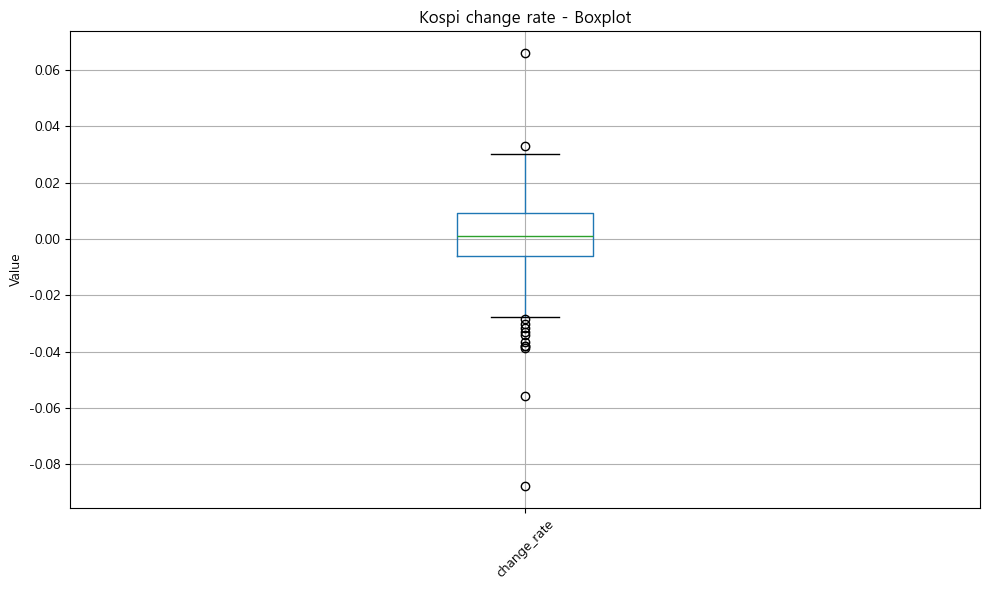

In [28]:
# 박스플롯(Boxplot)
# (1) 모든 컬럼 한 번에 (가장 많이 쓰는 방식)
# 박스플롯에서 보는 것
# 중앙값(median)
# 사분위수(Q1, Q3)
# 이상치(outliers)

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='Malgun Gothic')   # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))
df[['change_rate']].boxplot()
plt.title("Kospi change rate - Boxplot")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 2. 바이올린플롯(Violin Plot)

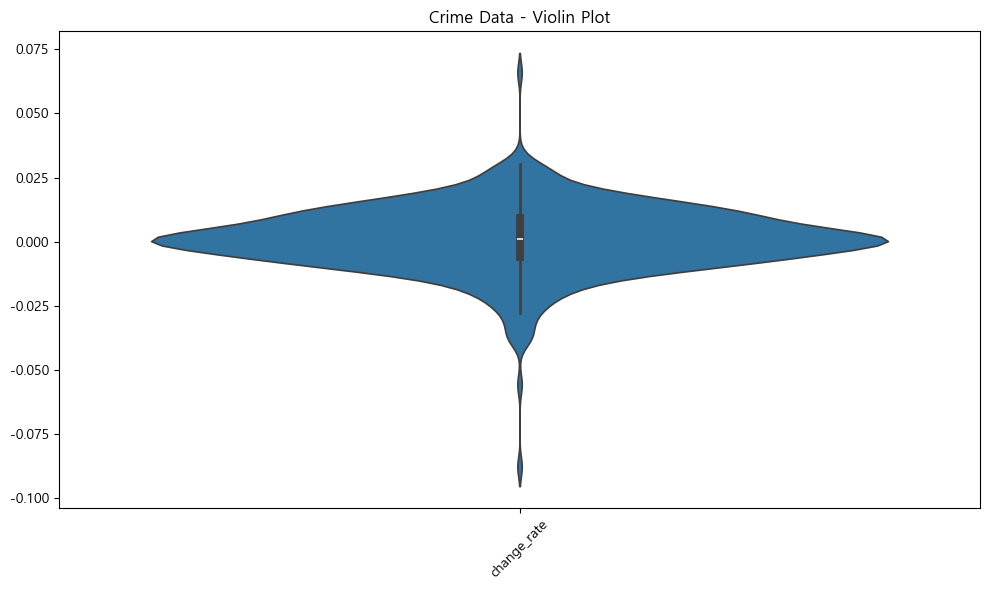

In [29]:
# 전체 컬럼 비교 
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[['change_rate']])
plt.title("Crime Data - Violin Plot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#  바이올린플롯 장점
# 분포 형태(밀도)까지 한눈에 확인
# 박스플롯 + 히스토그램 느낌

### 이상치(시장 이벤트) 최대,최소 변화비율 날짜 확인

In [30]:
event = df['change_rate'].idxmax()
event

np.int64(174)

In [31]:
event_row = df.loc[event]
event_row


basDt          20250410
idxNm               코스피
clpr            2445.06
change_rate    0.065989
Name: 174, dtype: object

In [32]:
event = df['change_rate'].idxmin()
event

np.int64(337)

In [33]:
event_row = df.loc[event]
event_row

basDt          20240805
idxNm               코스피
clpr            2441.55
change_rate   -0.087677
Name: 337, dtype: object

### 상승 이유 뉴스
https://www.nbnnews.co.kr/news/articleView.html?idxno=938176

### 하락 이유 뉴스
https://www.ytn.co.kr/_ln/0102_202408051759332263